In [20]:
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os


In [3]:
dataset = pd.read_csv("/content/emails.csv") #importing the dataset
dataset.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


**Preprocessing**

In [6]:
# Function to delete the first element of a string
def delete_first_element(text):
    return ' '.join(text.split()[1:])

# Apply the function to each row in the 'text' column
dataset['text'] = dataset['text'].apply(delete_first_element)
dataset

,text,spam
0,irresistible your corporate identity lt is rea...,1
1,stock trading gunslinger fanny is merrill but ...,1
2,new homes made easy im wanting to show you thi...,1
3,color printing special request additional info...,1
4,"not have money , get software cds from here ! ...",1
...,...,...
5723,: research and development charges to gpg here...,0
5724,": receipts from visit jim , thanks again for t...",0
5725,: enron case study update wow ! all on the sam...,0
5726,": interest david , please , call shirley crens...",0


In [11]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
def preprocess_text(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word.isalpha() and word not in stopwords.words('english')]
    return ' '.join(words)

dataset['processed_text'] = dataset['text'].apply(preprocess_text)
dataset

,text,spam,processed_text
0,irresistible your corporate identity lt is rea...,1,irresistible corporate identity lt really hard...
1,stock trading gunslinger fanny is merrill but ...,1,stock trading gunslinger fanny merrill muzo co...
2,new homes made easy im wanting to show you thi...,1,new homes made easy im wanting show homeowner ...
3,color printing special request additional info...,1,color printing special request additional info...
4,"not have money , get software cds from here ! ...",1,money get software cds software compatibility ...
...,...,...,...
5723,: research and development charges to gpg here...,0,research development charges gpg forwarded shi...
5724,": receipts from visit jim , thanks again for t...",0,receipts visit jim thanks invitation visit lsu...
5725,: enron case study update wow ! all on the sam...,0,enron case study update wow day super thank mu...
5726,": interest david , please , call shirley crens...",0,interest david please call shirley crenshaw as...


In [13]:
# Separate the DataFrame into two groups based on the 'spam' column
df_0 = dataset[dataset['spam'] == 0] # The group with spam value 0
df_1 = dataset[dataset['spam'] == 1] # The group with spam value 1

# Find the number of rows in the smaller group
n = min(len(df_0), len(df_1))

# Sample n rows from the larger group without replacement
df_0_balanced = df_0.sample(n, replace=False)

# Concatenate the balanced group with the smaller group
df_balanced = pd.concat([df_0_balanced, df_1])
df = df_balanced
df_balanced


,text,spam,processed_text
5498,: pending approval for ibuyit request for winc...,0,pending approval ibuyit request wincenty vince...
5559,": short - sell vs exercise chonawee , as i hav...",0,short sell vs exercise chonawee pointed short ...
2829,"' s a list of materials vince , here is my lis...",0,list materials vince list collected materials ...
5186,": wednesday vince , thanks for letting me know...",0,wednesday vince thanks letting know see wednes...
4568,3 ps : attached with the flyer of the conferen...,0,ps attached flyer conference quentin kerr emai...
...,...,...,...
1363,you ready to get it ? hello ! viagra is the # ...,1,ready get hello viagra med struggle mens erect...
1364,you like a $ 250 gas card ? don ' t let the cu...,1,like gas card let current high price gas get s...
1365,"reply needed dear sir , i am dr james alabi , ...",1,reply needed dear sir dr james alabi chairman ...
1366,see me get fisted ? fist bang will show you ev...,1,see get fisted fist bang show everything alway...


In [15]:
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
df_balanced

,text,spam,processed_text
0,collection of porn mo \ / ies ever - x 64 come...,1,collection porn mo ies ever x come explore wor...
1,software prices . big range of all types of do...,1,software prices big range types downloadable s...
2,vince / stinson : the following is an update o...,0,vince stinson following update ljm deal partic...
3,: current address for brad romine vince : i ha...,0,current address brad romine vince left brad tw...
4,mortgage rate vjd with regards to want to refi...,1,mortgage rate vjd regards want refinance fill ...
...,...,...,...
2731,"shalesh , please , look into it . can we give ...",0,shalesh please look give information see remot...
2732,stock rumored to fly special situation alerts ...,1,stock rumored fly special situation alerts hot...
2733,start desire in both men and women 7893 vbvfl ...,1,start desire men women vbvfl zkcc spring blow ...
2734,know your company ! lt is really hard to recol...,1,know company lt really hard recollect company ...


In [18]:
def count_word(word, column):
  words = df[column].astype(str).str.lower().str.split()
  counts = words.apply(lambda x: x.count(word))
  return counts.sum()

word = '0'
column = 'spam'
frequency_fixed_0 = count_word(word, column)
print(f'The word "{word}" appears {frequency_fixed_0} times in the column "{column}".')

word = '1'
column = 'spam'
frequency_fixed_1 = count_word(word, column)
print(f'The word "{word}" appears {frequency_fixed_1} times in the column "{column}".')




The word "0" appears 1368 times in the column "spam".
The word "1" appears 1368 times in the column "spam".


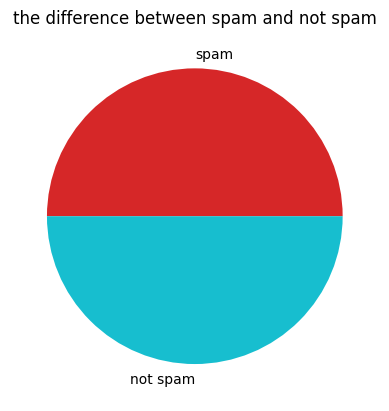

In [17]:
words = ['spam','not spam']
frequency = [frequency_fixed_1 , frequency_fixed_0]

# Plot a pie chart with labels and colors
plt.pie(frequency, labels=words, colors=['tab:red', 'tab:cyan']) #again my fav colors

# Add a title to the plot
plt.title('the difference between spam and not spam')

# Show the plot
plt.show()

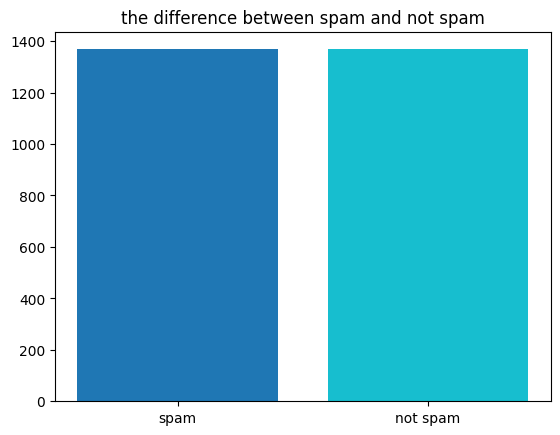

In [19]:
def plot():
  words = ['spam','not spam']
  freq = [frequency_fixed_1 , frequency_fixed_0]
  plt.bar(words,freq, color=['tab:blue', 'tab:cyan']) # I like them colors
  plt.title('the difference between spam and not spam')
  plt.show()
plot()

In [25]:
def split_data(df_balanced):
    # Split the data into train, validation, and test sets
    train_data, test_data = train_test_split(df_balanced, test_size=0.2, random_state=42)
    train_data, validation_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 20% validation of original data

    return train_data, validation_data, test_data

def store_splits(train_data, validation_data, test_data,directory='.'):

    # Store the splits in separate CSV files
    os.makedirs(directory,exist_ok=True)
    train_data.to_csv(os.path.join(directory,'train.csv'), index=False)
    validation_data.to_csv(os.path.join(directory,'validation.csv'), index=False)
    test_data.to_csv(os.path.join(directory,'test.csv'), index=False)

In [30]:
train_data, validation_data, test_data = split_data(df_balanced)
store_splits(train_data, validation_data, test_data)